# Initializing Code

## Install Library

In [131]:
!pip install --user yfinance



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import Libraries


In [132]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm
import yfinance as yf

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Defining Functions

In [133]:
# Maximum Drawdown Calculation
def drawdown(rets):
  """
  Takes a Stock Return from a DataFrame
  Computes:
  The Wealth Index
  The Previous Peaks
  Percent Drawdown
  Return:
  Percent Drawdown
  """

  wealth_index = 1000*(1+rets).cumprod()
  previous_peaks = wealth_index.cummax()
  drawdown = (wealth_index - previous_peaks)/previous_peaks
  return drawdown

In [134]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [135]:
# RSI Calculation

def rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods).mean()
        ma_down = down.rolling(window = periods).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

# Model 1: with MA(100) with a holding period of few days (Most successful until now)

## Execution

### Single Stock Data Analysis


In [136]:
# Manual Selected Pairs
'''

QQQ # NASDAQ 100
DIA # Dow Jones 30
SPY # SP500

'''

'\n\nQQQ # NASDAQ 100\nDIA # Dow Jones 30\nSPY # SP500\n\n'

Tckers to Change

In [137]:
# Tickers to Change ('CHD', 'MDLZ'), ('COST', 'EL'), ('DLTR', 'TSN'), ('HSY', 'MDLZ'), ('MDLZ', 'MKC')
# IMPORTANT ALWAYS PUT THE TICKERS BY ALPHABETICAL ORDER
tickers_list = ['GLD', 'GOLD']

In [138]:
# Parameters to Change
asset1 = tickers_list[0]
asset2 = tickers_list[1]

start = '2021-01-01'
end = None
interval = '1d'

# Fetch the data
data = yf.download(tickers_list, start = start, end = end, interval = interval)['Close'] # Year - Month - Day

[*********************100%***********************]  2 of 2 completed


In [139]:
data

,GLD,GOLD
Date,,
2021-01-04,182.330002,24.620001
2021-01-05,182.869995,24.280001
2021-01-06,179.899994,24.500000
2021-01-07,179.479996,24.770000
2021-01-08,173.339996,23.969999
...,...,...
2023-03-03,172.490005,16.520000
2023-03-06,171.619995,16.299999
2023-03-07,168.619995,15.770000


### Spread Analysis

In [140]:
# MA Parameters
ma_reversion_window = 100
stdv_window = 20
ma_entry_window = 20

In [141]:
# Spread Analysis
# Indexed Returns
data[f"{asset1} Indexed"] = (data[asset1].pct_change()+1).cumprod()
data[f"{asset2} Indexed"] = (data[asset2].pct_change()+1).cumprod()


# Spread Analysis and Computation
data['Ratio Spread'] = data[asset1] / data[asset2]
data['MA Reversion'] = data['Ratio Spread'].rolling(window= ma_reversion_window).mean()

data['Spread vs MA'] = data['Ratio Spread'] - data['MA Reversion']


data['z-score'] = zscore(data['Spread vs MA'])
data['s+1'] = +1
data['s-1'] = -1
data['s+2'] = +2
data['s-2'] = -2
data['s+3'] = +3
data['s-3'] = -3


data['MA Entry'] = data['z-score'].rolling(window= ma_entry_window).mean()

data

,GLD,GOLD,GLD Indexed,GOLD Indexed,Ratio Spread,MA Reversion,Spread vs MA,z-score,s+1,s-1,s+2,s-2,s+3,s-3,MA Entry
Date,,,,,,,,,,,,,,,
2021-01-04,182.330002,24.620001,NaN,NaN,7.405767,NaN,NaN,NaN,1,-1,2,-2,3,-3,NaN
2021-01-05,182.869995,24.280001,1.002962,0.986190,7.531713,NaN,NaN,NaN,1,-1,2,-2,3,-3,NaN
2021-01-06,179.899994,24.500000,0.986672,0.995126,7.342857,NaN,NaN,NaN,1,-1,2,-2,3,-3,NaN
2021-01-07,179.479996,24.770000,0.984369,1.006093,7.245862,NaN,NaN,NaN,1,-1,2,-2,3,-3,NaN
2021-01-08,173.339996,23.969999,0.950694,0.973599,7.231539,NaN,NaN,NaN,1,-1,2,-2,3,-3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-03,172.490005,16.520000,0.946032,0.670999,10.441283,9.933016,0.508267,0.334683,1,-1,2,-2,3,-3,-0.146130
2023-03-06,171.619995,16.299999,0.941260,0.662063,10.528835,9.936484,0.592351,0.441668,1,-1,2,-2,3,-3,-0.077147
2023-03-07,168.619995,15.770000,0.924807,0.640536,10.692453,9.940037,0.752416,0.645329,1,-1,2,-2,3,-3,0.001297


### Final Data Visualized

In [142]:
data = data

data.drop(index= data.index[0], 
        axis=0, 
        inplace=True)

In [143]:
data.dropna(inplace = True)
data

,GLD,GOLD,GLD Indexed,GOLD Indexed,Ratio Spread,MA Reversion,Spread vs MA,z-score,s+1,s-1,s+2,s-2,s+3,s-3,MA Entry
Date,,,,,,,,,,,,,,,
2021-06-23,166.139999,20.959999,0.911205,0.851340,7.926527,7.717759,0.208768,-0.046390,1,-1,2,-2,3,-3,-0.415597
2021-06-24,166.039993,20.969999,0.910656,0.851746,7.917978,7.719641,0.198337,-0.059662,1,-1,2,-2,3,-3,-0.374157
2021-06-25,166.589996,20.889999,0.913673,0.848497,7.974629,7.722346,0.252283,0.008977,1,-1,2,-2,3,-3,-0.343319
2021-06-28,166.580002,20.700001,0.913618,0.840780,8.047343,7.725894,0.321448,0.096981,1,-1,2,-2,3,-3,-0.305600
2021-06-29,164.830002,20.530001,0.904020,0.833875,8.028738,7.729715,0.299023,0.068447,1,-1,2,-2,3,-3,-0.264559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-03,172.490005,16.520000,0.946032,0.670999,10.441283,9.933016,0.508267,0.334683,1,-1,2,-2,3,-3,-0.146130
2023-03-06,171.619995,16.299999,0.941260,0.662063,10.528835,9.936484,0.592351,0.441668,1,-1,2,-2,3,-3,-0.077147
2023-03-07,168.619995,15.770000,0.924807,0.640536,10.692453,9.940037,0.752416,0.645329,1,-1,2,-2,3,-3,0.001297


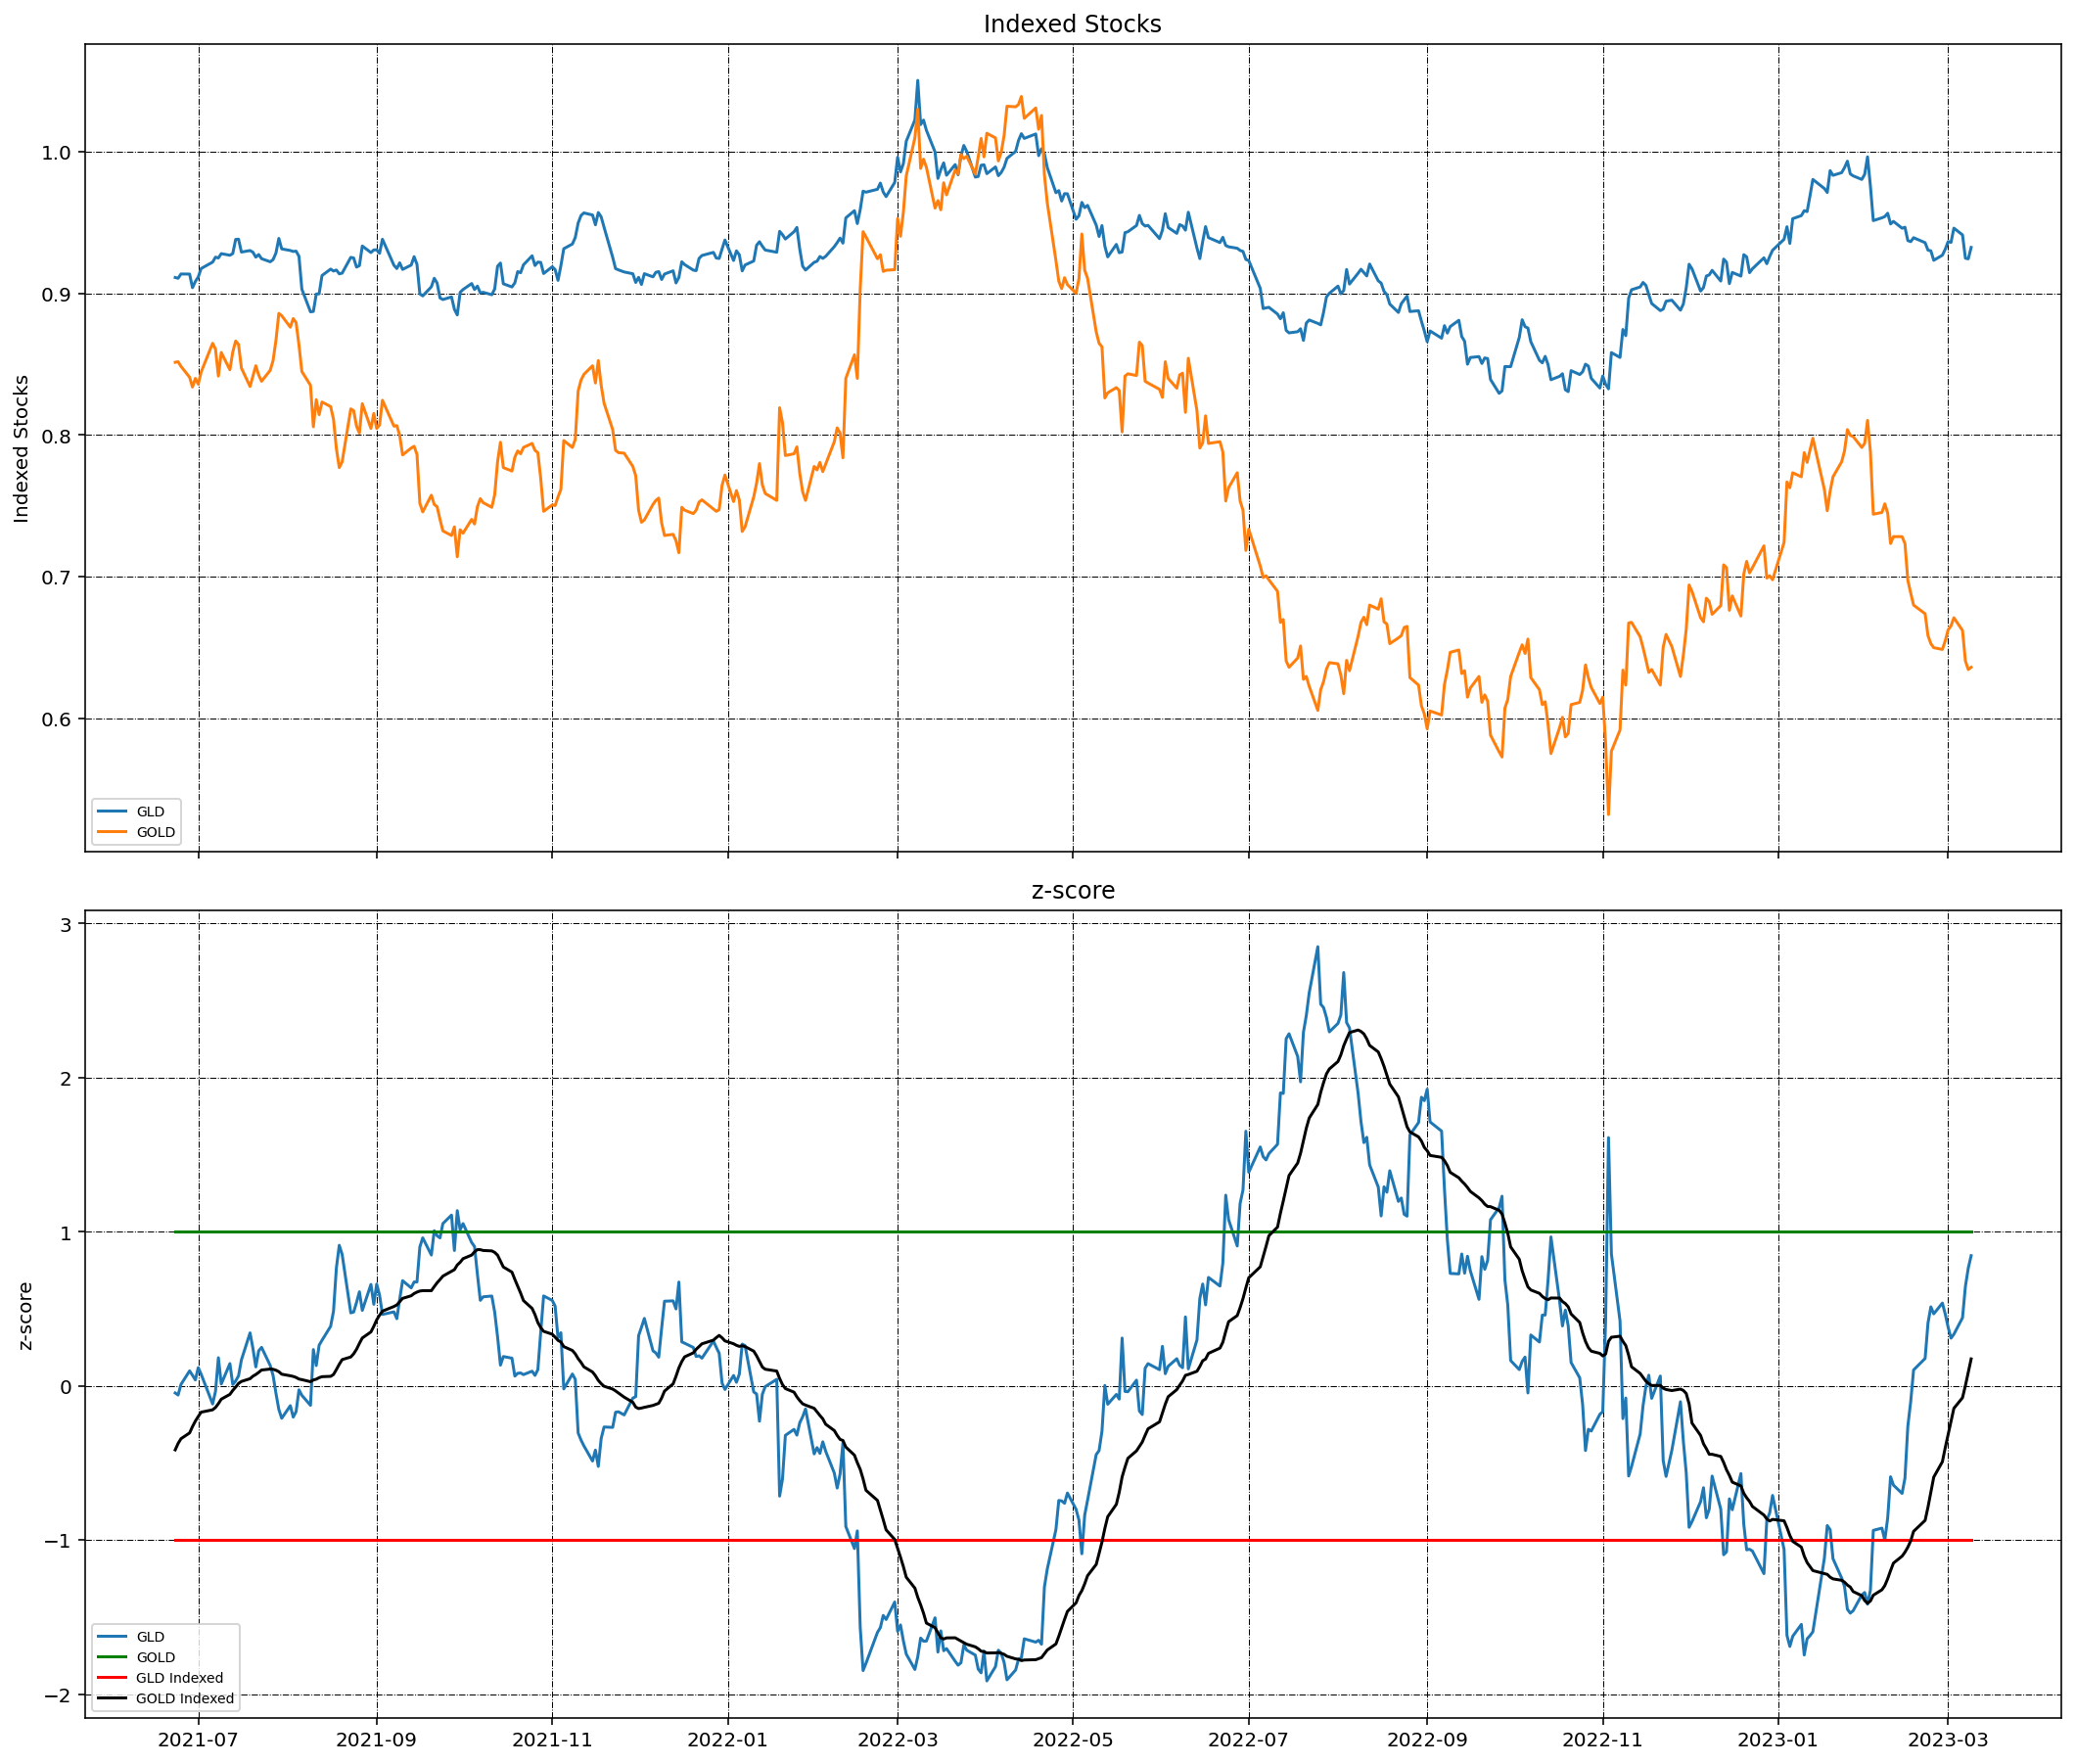

In [144]:
# Show a Graph of the SVR on Ratio and Spread z-score
#Initial Figure
fig, axs = plt.subplots(2, sharex=True, figsize=(15,13))
fig.suptitle('')
fig.tight_layout(pad=2.0)


# 1th graph
#Data
axs[0].plot(data[f"{asset1} Indexed"])
axs[0].plot(data[f"{asset2} Indexed"])
#Layout
axs[0].set_title('Indexed Stocks')
axs[0].legend(data, loc="lower left", prop={'size': 7}, shadow = False)
axs[0].set_ylabel('Indexed Stocks')
axs[0].grid(which="major", color='k', linestyle='-.', linewidth=0.5)


# 2rd graph
#Data
axs[1].plot(data['z-score'])
axs[1].plot(data['s+1'], label="s1", color="green")
axs[1].plot(data['s-1'], label="s-1", color="red")
#axs[2].plot(data['s+2'], label="s2", color="green")
#axs[2].plot(data['s-2'], label="s-2", color="red")
#axs[2].plot(data['s+3'], label="s3", color="green")
#axs[2].plot(data['s-3'], label="s-3", color="red")
axs[1].plot(data['MA Entry'], label="MA Entry", color="black")
#Layout
axs[1].set_title('z-score')
axs[1].legend(data, loc="lower left", prop={'size': 7}, shadow = False)
axs[1].set_ylabel('z-score')
axs[1].grid(which="major", color='k', linestyle='-.', linewidth=0.5)


#### Trial for the new formula

In [145]:
'''
SL1 = 0.2 # 20%
TP1 = 0.8 # 60%
SL2 = 0.2 # 10%
TP2 = 0.8 # 60%
Stop_Loss_lvl = Position Taken - 20% 
Take_Profit_lvl

'''

'\nSL1 = 0.2 # 20%\nTP1 = 0.8 # 60%\nSL2 = 0.2 # 10%\nTP2 = 0.8 # 60%\nStop_Loss_lvl = Position Taken - 20% \nTake_Profit_lvl\n\n'

In [146]:
# Add a Dynamic condition for the SL and TP
SL1 = 0.4 # 40%
TP1 = 0.8 # 80%

# when I open the Position, I want to put a Stop Loss that will be 40% away from the buy_signal generated or if the Spread <= MA entry, execute stop loss


In [147]:
# Stop Loss and Take Profit
#this one u need to modify to only take the percentages he asked for
#Works 1 excel conditional formating (coloring the data)
#create a function to signal when to buy and sell the stock (NEW CODE)
#this is the dynamic version
def buy_sell_dynamic(data):
  #Create Empty lists
  Buy_signal1 = np.full([len(data)], np.nan)
  Sell_signal1 = np.full([len(data)], np.nan)
  Stop_Loss_lvl = np.full([len(data)], np.nan)
  Take_Profit_lvl = np.full([len(data)], np.nan)

  position = False #true if open, false if closed
  
  #flag = -1 #when the Spread hit a threshold

  for i in range(len(data)): #for each itteration, until the data is finished (lendata)
    if not position: #SELL
      if data['z-score'][i] >= data['s+1'][i] and data['z-score'][i] <= data['MA Entry'][i]:
        Sell_signal1[i] = data['MA Entry'][i]
        Stop_Loss_lvl[i] = data['z-score'][i] - data['z-score'][i]* SL1
        Take_Profit_lvl[i] = data['z-score'][i] + data['z-score'][i]* TP1 #TP
        position = True
    
    else: #BUY
      if data['z-score'][i] >= data['MA Entry'][i]:
        position = False
        Buy_signal1[i] = data['MA Entry'][i]
        Stop_Loss_lvl[i] = data['z-score'][i] + data['z-score'][i]* SL1 #SL
        Take_Profit_lvl[i] = data['z-score'][i] - data['z-score'][i]* TP1 #TP
  return(Buy_signal1, Sell_signal1, Stop_Loss_lvl, Take_Profit_lvl)
        


### SL and TP (1st Code ok, Have to Adjust the Syntax)

In [148]:
#modify
# mentions that you have to remove 
#no more percentages, just upper and lower limit
SL1 = 0.2 # 20%
TP1 = 0.8 # 60%
#SL2 = 0.2 # 10% #remove 
#TP2 = 0.8 # 60% #remove

In [149]:
np.full([10], np.nan)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [150]:
#store the buy and sell data into a variable (NEW CODE)
bu_sell = buy_sell_dynamic(data) #create a variable

data['Buy_signal1'] = bu_sell[0]
data['Sell_signal1'] = bu_sell[1]
data['Stop_Loss_lvl'] = bu_sell[2]
data['Take_Profit_lvl'] = bu_sell[3]

In [151]:
data.loc[data["Sell_signal1"].dropna().index]

,GLD,GOLD,GLD Indexed,GOLD Indexed,Ratio Spread,MA Reversion,Spread vs MA,z-score,s+1,s-1,s+2,s-2,s+3,s-3,MA Entry,Buy_signal1,Sell_signal1,Stop_Loss_lvl,Take_Profit_lvl
Date,,,,,,,,,,,,,,,,,,,
2022-08-08,166.690002,16.200001,0.914221,0.658002,10.289506,8.552605,1.736901,1.897955,1,-1,2,-2,3,-3,2.308663,NaN,2.308663,1.518364,3.416318
2022-09-07,159.940002,15.360000,0.877201,0.623883,10.412761,9.164024,1.248737,1.276831,1,-1,2,-2,3,-3,1.460770,NaN,1.460770,1.021465,2.298297


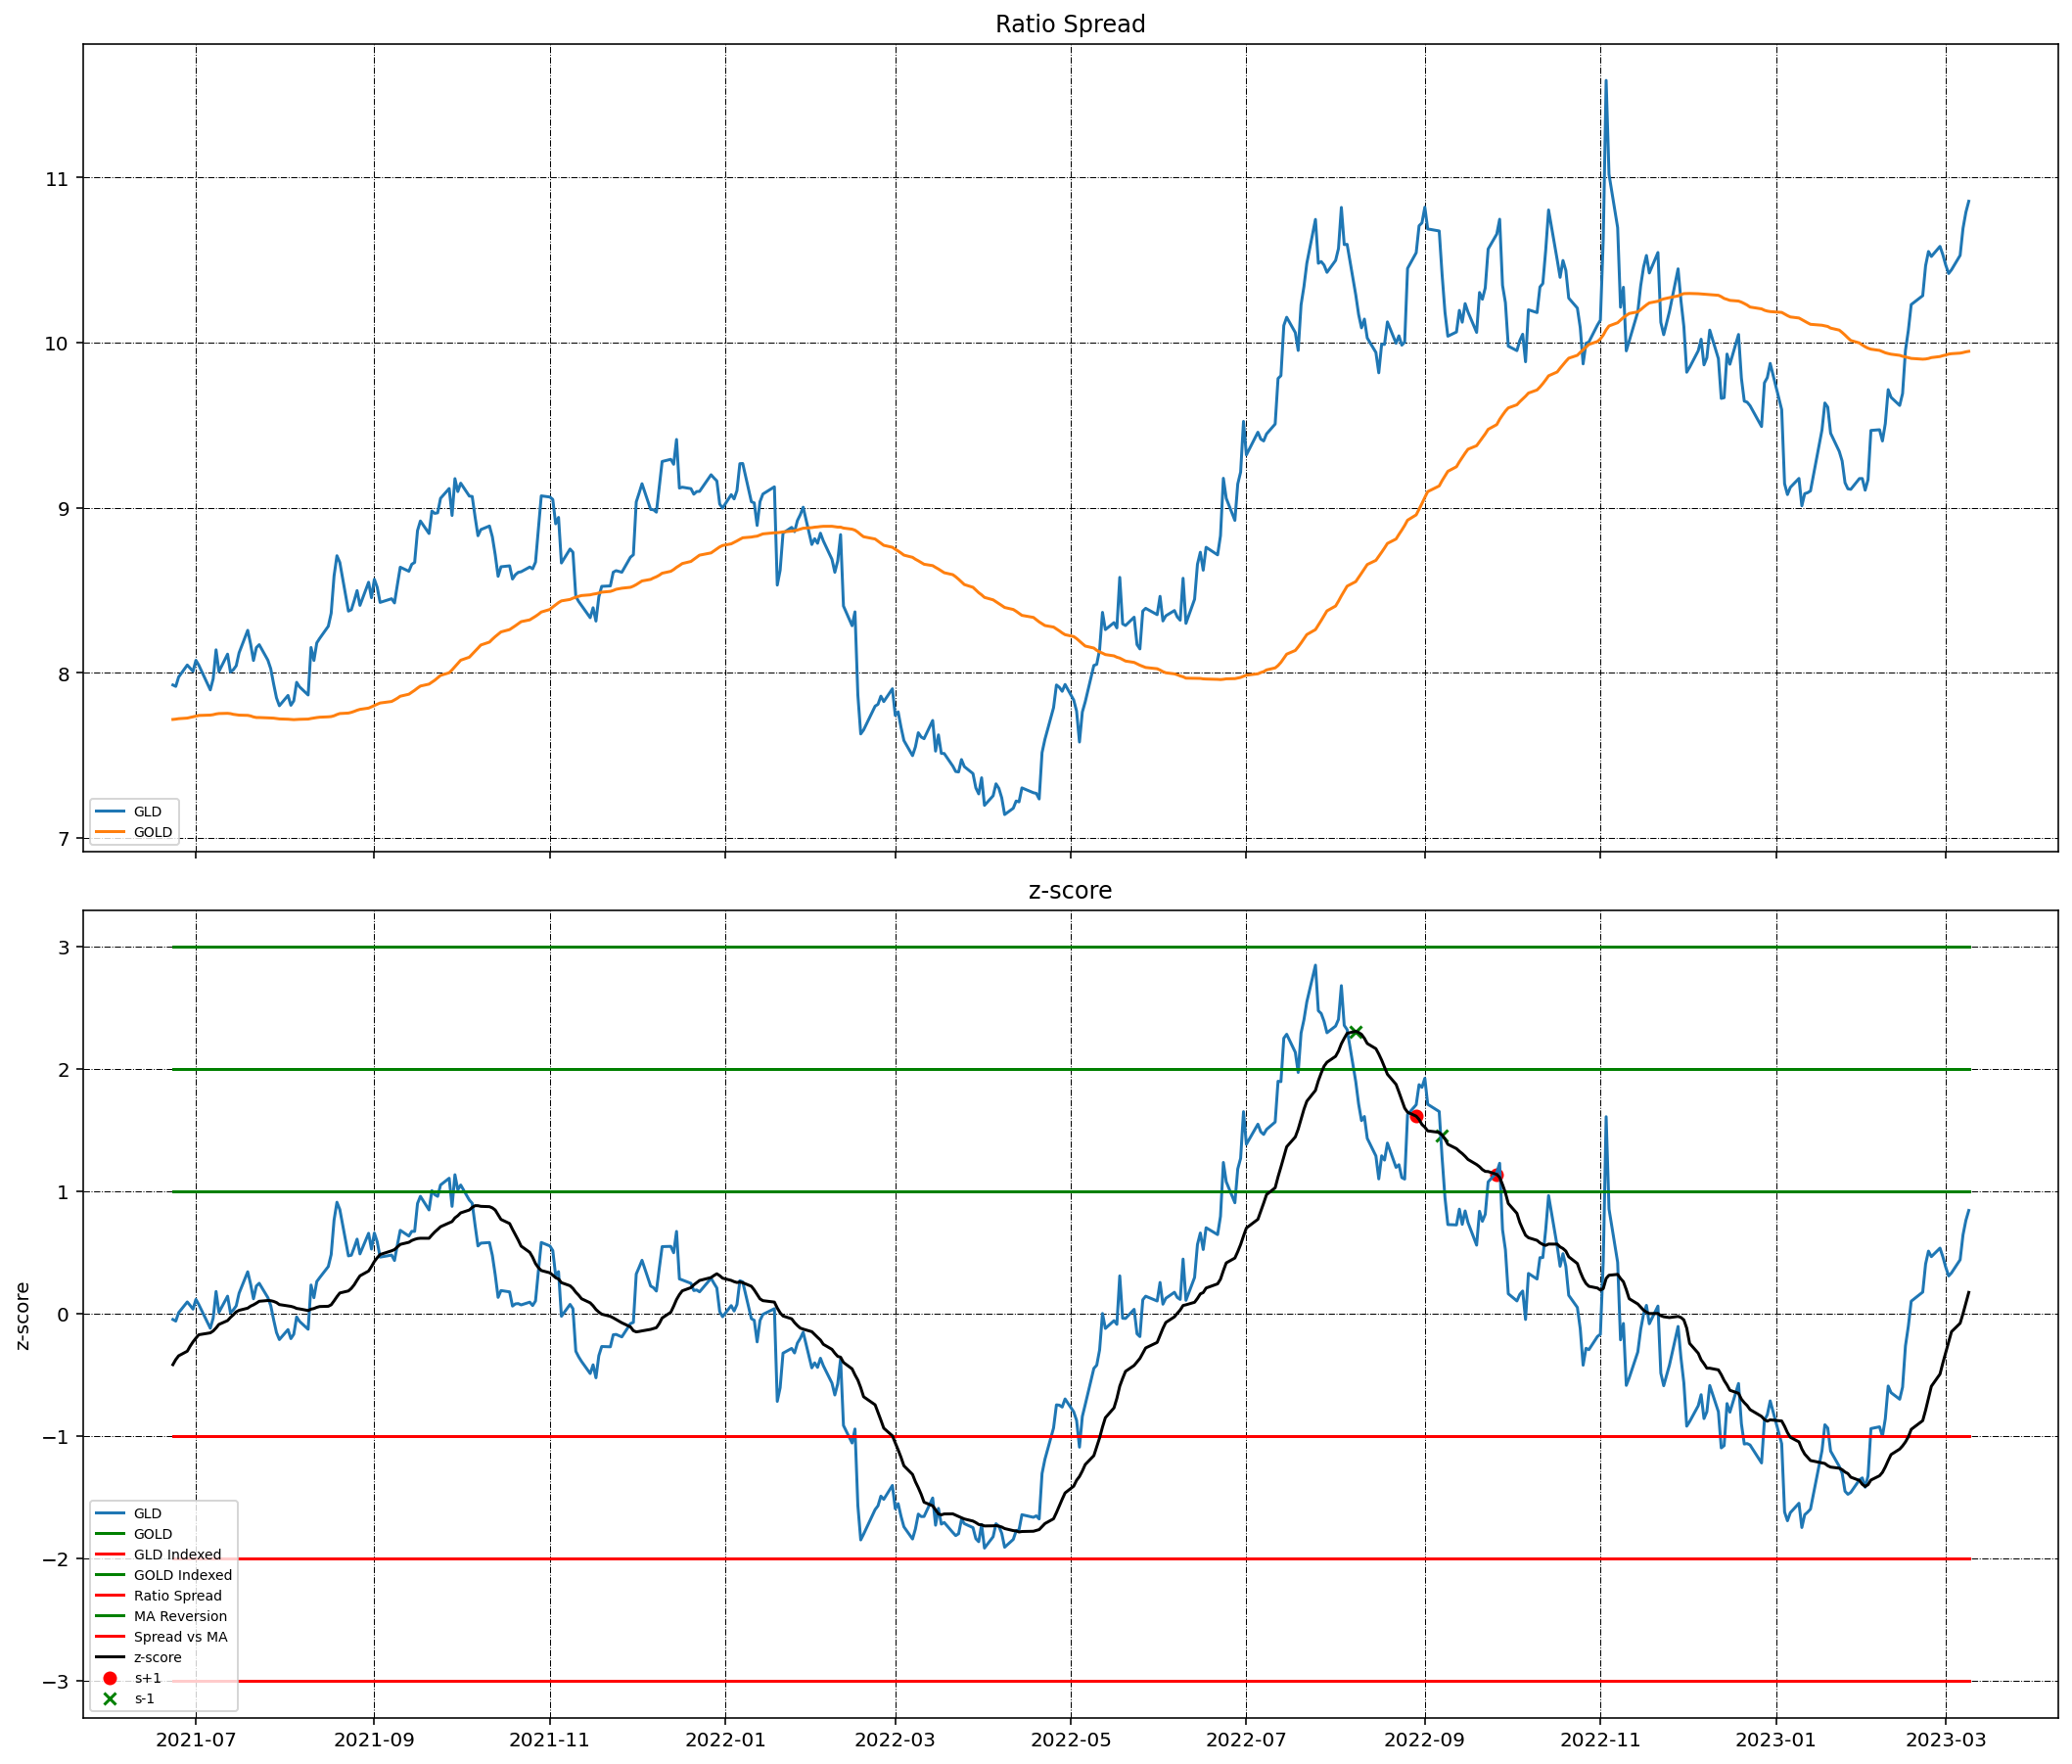

In [152]:
# Show a Graph of the SVR on Ratio and Spread z-score
#Initial Figure
fig, axs = plt.subplots(2, sharex=True, figsize=(15,13))
fig.suptitle('')
fig.tight_layout(pad=2.0)

# 1st graph
#Data
axs[0].plot(data['Ratio Spread'])
axs[0].plot(data['MA Reversion'])
#Layout
axs[0].set_title('Ratio Spread') # change to spread of the tickers
axs[0].legend(data, loc="lower left", prop={'size': 7}, shadow = False)
axs[0].set_ylabel('')
axs[0].grid(which="major", color='k', linestyle='-.', linewidth=0.5)



# 3rd graph
#Data
axs[1].plot(data['z-score'])
axs[1].plot(data['s+1'], label="s1", color="green")
axs[1].plot(data['s-1'], label="s-1", color="red")
axs[1].plot(data['s+2'], label="s2", color="green")
axs[1].plot(data['s-2'], label="s-2", color="red")
axs[1].plot(data['s+3'], label="s3", color="green")
axs[1].plot(data['s-3'], label="s-3", color="red")
axs[1].plot(data['MA Entry'], label="MA Entry", color="black")


#data['Buy_signal1'] = data['Buy_signal1'].astype(bool)
#data['Sell_signal1'] = data['Sell_signal1'].astype(bool) 
#mark Buy_signal1 and Sell_signal1 with an "x"

axs[1].scatter(x=data["Buy_signal1"].index, y=data['Buy_signal1'], marker='o', color='red', label = "BUY")
axs[1].scatter(x=data["Sell_signal1"].index, y=data['Sell_signal1'], marker='x', color='green', label = "SELL")


#axs[1].plot(data['Stop_Loss_lvl'])
#axs[1].plot(data['Take_Profit_lvl'])

#Layout
axs[1].set_title('z-score')
axs[1].legend(data, loc="lower left", prop={'size': 7}, shadow = False)
axs[1].set_ylabel('z-score')
axs[1].grid(which="major", color='k', linestyle='-.', linewidth=0.5)

In [153]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 431 entries, 2021-06-23 to 2023-03-09
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GLD              431 non-null    float64
 1   GOLD             431 non-null    float64
 2   GLD Indexed      431 non-null    float64
 3   GOLD Indexed     431 non-null    float64
 4   Ratio Spread     431 non-null    float64
 5   MA Reversion     431 non-null    float64
 6   Spread vs MA     431 non-null    float64
 7   z-score          431 non-null    float64
 8   s+1              431 non-null    int64  
 9   s-1              431 non-null    int64  
 10  s+2              431 non-null    int64  
 11  s-2              431 non-null    int64  
 12  s+3              431 non-null    int64  
 13  s-3              431 non-null    int64  
 14  MA Entry         431 non-null    float64
 15  Buy_signal1      2 non-null      float64
 16  Sell_signal1     2 non-null      float64
 1

In [154]:
data_2 = pd.DataFrame(data, columns = ['z-score','Buy_signal1', 'Sell_signal1', 'Stop_Loss_lvl', 'Take_Profit_lvl', 'PandL', 'CumPandL'])

In [155]:
#Initialize the Variables needed
#Position size that can be traded
position_size_per_spread_signal1 = 100
position_size_per_spread_signal2 = 200

#Position size that can be traded
Maximum_Position_Size = 2
Actual_Position_Size = 0
Entry_Long = 0
Entry_Short = 0

#Fixing initial Values of different thrseholds (if we have more room to enter more positions, we double the work done later)
stop_loss_value_pos1 = 0     # SL of the FIRST position opened
stop_loss_value_pos2 = 0     # SL of the SECOND position opened
take_profit_value_pos1 = 0   # TP of the FIRST position opened
take_profit_value_pos2 = 0   # TP of the SECOND position opened

#initial spread size (at position i)
buy_place_pos1 = 0
buy_place_pos2 = 0

position_size_per_spread_pos1 = 0
position_size_per_spread_pos2 = 0

#create empty lists used in Plotting graphs, where x and y are the coordinates of the data
entry_long_x = []
entry_long_y = []

entry_short_x = []
entry_short_y = []

stop_loss_x = []
stop_loss_y = []

In [156]:
for i in range(len(data_2)): #for each itteration, until the data is finished (lendata)
# start with the Closing Position Part because after closing a position,
# we want to enter the same position at the same date while changing our SL and TP  
# check if Actual Position Size is lower than Maximum Position Size to execute the order (position 1)
  if stop_loss_value_pos1 != 0 and take_profit_value_pos1 != 0 and buy_place_pos1 != 0 and position_size_per_spread_pos1 != 0:

    if data_2['z-score'][i] >= 0: # Positive Side (Short Selling) Closing position 1 opened

      if data_2['z-score'][i] > stop_loss_value_pos1: #Loss calculation, SL hit
        data_2['PandL'][buy_place_pos1] = (data_2['z-score'][buy_place_pos1] - stop_loss_value_pos1) * position_size_per_spread_pos1 
        Actual_Position_Size = 1          #Closing the position --> itterate actual position by -1 
        stop_loss_value_pos1 = 0           #reset variables to 0
        take_profit_value_pos1 = 0         #reset variables to 0
        buy_place_pos1 = 0                 #reset variables to 0
        position_size_per_spread_pos1 = 0  #reset variables to 0

        stop_loss_x.append(i)                     #graph plotting (Black bars markers)
        stop_loss_y.append(data_2['z-score'][i])   #graph plotting (Black bars markers)

      elif data_2['z-score'][i] < take_profit_value_pos1: #Profit calculation, TP hit
        data_2['PandL'][buy_place_pos1] = ( - data_2['z-score'][i] + data_2['z-score'][buy_place_pos1]) * position_size_per_spread_pos1 
        
        entry_long_x.append(i)                                  #graph plotting (Green Arrows)
        entry_long_y.append(data_2['z-score'][i])                #graph plotting (Green Arrows)

        entry_short_x.append(buy_place_pos1)                    #graph plotting (Green Arrows)
        entry_short_y.append(data_2['z-score'][buy_place_pos1])  #graph plotting (Green Arrows)        
        
        Actual_Position_Size = 1
        stop_loss_value_pos1 = 0
        take_profit_value_pos1 = 0
        buy_place_pos1 = 0
        position_size_per_spread_pos1 = 0



    else: # Negative Side (Long Buying) Closing position 1 opened

      if data_2['z-score'][i] < stop_loss_value_pos1: #Loss calculation, SL hit
        data_2['PandL'][buy_place_pos1] = ( - data_2['z-score'][buy_place_pos1] + stop_loss_value_pos1) * position_size_per_spread_pos1
        Actual_Position_Size -= 1
        stop_loss_value_pos1 = 0
        take_profit_value_pos1 = 0
        buy_place_pos1 = 0
        position_size_per_spread_pos1 = 0

        stop_loss_x.append(i)                                 #graph plotting (Black bars markers)
        stop_loss_y.append(data_2['z-score'][i])               #graph plotting (Black bars markers)

      elif data_2['z-score'][i] > take_profit_value_pos1: #Profit calculation, TL hit
        data_2['PandL'][buy_place_pos1] = (data_2['z-score'][i] - data_2['z-score'][buy_place_pos1]) * position_size_per_spread_pos1
        
        entry_long_x.append(buy_place_pos1)                    #graph plotting (Red Arrows)
        entry_long_y.append(data_2['z-score'][buy_place_pos1])  #graph plotting (Red Arrows)

        entry_short_x.append(i)                                #graph plotting (Red Arrows)
        entry_short_y.append(data_2['z-score'][i])              #graph plotting (Red Arrows)
        
        Actual_Position_Size = 1
        stop_loss_value_pos1 = 0
        take_profit_value_pos1 = 0
        buy_place_pos1 = 0
        position_size_per_spread_pos1 = 0

# check if Actual Position Size is lower than Maximum Position Size to execute the order (position 2) (same procedure as 1)
  if stop_loss_value_pos2 != 0 and take_profit_value_pos2 != 0 and buy_place_pos2 != 0 and position_size_per_spread_pos2 != 0:

    if data_2['z-score'][i] >= 0: # Positive Side (Short Selling) Closing position 2 opened

      if data_2['z-score'][i] > stop_loss_value_pos2: #Loss calculation, SL hit
        data_2['PandL'][buy_place_pos2] = (data_2['z-score'][buy_place_pos2] - stop_loss_value_pos2) * position_size_per_spread_pos2
        Actual_Position_Size -= 1
        stop_loss_value_pos2 = 0
        take_profit_value_pos2 = 0
        buy_place_pos2 = 0
        position_size_per_spread_pos2 = 0

        stop_loss_x.append(i)
        stop_loss_y.append(data_2['z-score'][i])

      elif data_2['z-score'][i] < take_profit_value_pos2: #Profit calculation, TP hit
        data_2['PandL'][buy_place_pos2] = ( - data_2['z-score'][i] + data_2['z-score'][buy_place_pos2]) * position_size_per_spread_pos2
        
        entry_long_x.append(i)
        entry_long_y.append(data_2['z-score'][i])

        entry_short_x.append(buy_place_pos2)
        entry_short_y.append(data_2['z-score'][buy_place_pos2])
        
        Actual_Position_Size = 1
        stop_loss_value_pos2 = 0
        take_profit_value_pos2 = 0
        buy_place_pos2 = 0
        position_size_per_spread_pos2 = 0

    else: # Negative Side (Long Buying) Closing position 2 opened

      if data_2['z-score'][i] < stop_loss_value_pos2: #Loss calculation, SL hit
        data_2['PandL'][buy_place_pos2] = ( - data_2['z-score'][buy_place_pos2] + stop_loss_value_pos2) * position_size_per_spread_pos2
        Actual_Position_Size -= 1
        stop_loss_value_pos2 = 0
        take_profit_value_pos2 = 0
        buy_place_pos2 = 0
        position_size_per_spread_pos2 = 0

        stop_loss_x.append(i)
        stop_loss_y.append(data_2['z-score'][i])

      elif data_2['z-score'][i] > take_profit_value_pos2: #Profit calculation, TP hit
        data_2['PandL'][buy_place_pos2] = (data_2['z-score'][i] - data_2['z-score'][buy_place_pos2]) * position_size_per_spread_pos2
        
        entry_long_x.append(buy_place_pos2)
        entry_long_y.append(data_2['z-score'][buy_place_pos2])

        entry_short_x.append(i)
        entry_short_y.append(data_2['z-score'][i])
        
        Actual_Position_Size = 1
        stop_loss_value_pos2 = 0
        take_profit_value_pos2 = 0
        buy_place_pos2 = 0
        position_size_per_spread_pos2 = 0


  if Actual_Position_Size < Maximum_Position_Size: #execute orders if condition is True
    #Buy Signal 1 Entry Position Long
    if not np.isnan(data_2['Buy_signal1'][i]): #Buy1

      Actual_Position_Size += 1 #increment the count by 1

      if stop_loss_value_pos1 == 0 and take_profit_value_pos1 == 0 and buy_place_pos1 == 0 and position_size_per_spread_pos1 == 0: #Variables are empty
        stop_loss_value_pos1 = data_2['Stop_Loss_lvl'][i]
        take_profit_value_pos1 = data_2['Take_Profit_lvl'][i]
        position_size_per_spread_pos1 = position_size_per_spread_signal1 #100
        buy_place_pos1 = i #initial Spread
      else:
        stop_loss_value_pos2 = data_2['Stop_Loss_lvl'][i]
        take_profit_value_pos2 = data_2['Take_Profit_lvl'][i]
        position_size_per_spread_pos2 = position_size_per_spread_signal1
        buy_place_pos2 = i

    #Sell Signal 1 Entry Position Short 
    elif not np.isnan(data_2['Sell_signal1'][i]): #Sell1

      Actual_Position_Size += 1

      if stop_loss_value_pos1 == 0 and take_profit_value_pos1 == 0 and buy_place_pos1 == 0 and position_size_per_spread_pos1 == 0:
        stop_loss_value_pos1 = data_2['Stop_Loss_lvl'][i]
        take_profit_value_pos1 = data_2['Take_Profit_lvl'][i]
        position_size_per_spread_pos1 = position_size_per_spread_signal1
        buy_place_pos1 = i
      else:
        stop_loss_value_pos2 = data_2['Stop_Loss_lvl'][i]
        take_profit_value_pos2 = data_2['Take_Profit_lvl'][i]
        position_size_per_spread_pos2 = position_size_per_spread_signal1
        buy_place_pos2 = i

    #Sell Signal 2 Entry Position Shorts
   
    # NO Entry Position
    else:
      data_2['PandL'][i] = np.nan

# NO Entry Position
  else:
    data_2['PandL'][i] = np.nan
     


In [157]:
data = data.reset_index()
data

,Date,GLD,GOLD,GLD Indexed,GOLD Indexed,Ratio Spread,MA Reversion,Spread vs MA,z-score,s+1,s-1,s+2,s-2,s+3,s-3,MA Entry,Buy_signal1,Sell_signal1,Stop_Loss_lvl,Take_Profit_lvl
0,2021-06-23,166.139999,20.959999,0.911205,0.851340,7.926527,7.717759,0.208768,-0.046390,1,-1,2,-2,3,-3,-0.415597,NaN,NaN,NaN,NaN
1,2021-06-24,166.039993,20.969999,0.910656,0.851746,7.917978,7.719641,0.198337,-0.059662,1,-1,2,-2,3,-3,-0.374157,NaN,NaN,NaN,NaN
2,2021-06-25,166.589996,20.889999,0.913673,0.848497,7.974629,7.722346,0.252283,0.008977,1,-1,2,-2,3,-3,-0.343319,NaN,NaN,NaN,NaN
3,2021-06-28,166.580002,20.700001,0.913618,0.840780,8.047343,7.725894,0.321448,0.096981,1,-1,2,-2,3,-3,-0.305600,NaN,NaN,NaN,NaN
4,2021-06-29,164.830002,20.530001,0.904020,0.833875,8.028738,7.729715,0.299023,0.068447,1,-1,2,-2,3,-3,-0.264559,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,2023-03-03,172.490005,16.520000,0.946032,0.670999,10.441283,9.933016,0.508267,0.334683,1,-1,2,-2,3,-3,-0.146130,NaN,NaN,NaN,NaN
427,2023-03-06,171.619995,16.299999,0.941260,0.662063,10.528835,9.936484,0.592351,0.441668,1,-1,2,-2,3,-3,-0.077147,NaN,NaN,NaN,NaN
428,2023-03-07,168.619995,15.770000,0.924807,0.640536,10.692453,9.940037,0.752416,0.645329,1,-1,2,-2,3,-3,0.001297,NaN,NaN,NaN,NaN
429,2023-03-08,168.539993,15.620000,0.924368,0.634444,10.790012,9.944358,0.845654,0.763962,1,-1,2,-2,3,-3,0.089550,NaN,NaN,NaN,NaN


In [158]:
#Simple calculations
account_amount = 100000 #100,000$
Short_position_margin = 1.5 #150%
Maximum_short_position_size = account_amount / Short_position_margin #66,666$
#Maximum_spread_size = Maximum_short_position_size / df['PEP'].max() #Max spread size based on the short margin limitation
#Position_size_per_pread = Maximum_spread_size / 2 #Safe Position sizing to protect the short margin 
#Position_actual_size = Position_size_per_pread / Maximum_spread_size # used later to backtest correctly the actual size
#transform to input (Optional)
print('Account Amount ' + str(account_amount))
print('Short Position Margin in % ' + str(Short_position_margin * 100))
print('Maximum Short Position Size ' + str(Maximum_short_position_size))
#print('Maximum Spread Size ' + str(Maximum_spread_size))
#print('Position Size per Spread ' + str(Position_size_per_pread))
#print('Position Actual Size ' + str(Position_actual_size))

Account Amount 100000
Short Position Margin in % 150.0
Maximum Short Position Size 66666.66666666667


In [159]:
current_balance = account_amount

for i in range(len(data_2)):

  if not np.isnan(data_2['PandL'][i]):

    current_balance += data_2['PandL'][i]

    data_2['CumPandL'][i] = current_balance

  else:

    data_2['CumPandL'][i] = current_balance

data_2.to_csv('newdata2.csv')

In [160]:
number_of_years = 4


#Total number of profitable trades 
#Total value of profitable trades
#Total number of losing trades
#Total value of losing trades
#Maximum loss (drawdown) 


Total_Strategy_PandL_in_USD = data_2['PandL'].sum()
Annualized_Strategy_PandL_in_USD = data_2['PandL'].sum() / number_of_years 
Strategy_ROI = (data_2['PandL'].sum() / account_amount) * 100
Annualized_Strategy_ROI = (Annualized_Strategy_PandL_in_USD / account_amount) * 100
Total_number_of_profitable_trades = data_2['PandL'].gt(0).sum() #double check
Total_number_of_losing_trades = data_2['PandL'].lt(0).sum() #double check


print('Total strategy P&L in $ value: ' + str(round(Total_Strategy_PandL_in_USD, 2)) + ' $')
print('Annualized Strategy P&L in $ value: ' + str(round(Annualized_Strategy_PandL_in_USD, 2)) + ' $')
print('Total Strategy P&L in % (Return on Investment): ' + str(round(Strategy_ROI, 2)) + ' %')
print('Annualized Strategy P&L in % (Return on Investment): ' + str(round(Annualized_Strategy_ROI, 2)) + ' %')
print('Total number of profitable trades: ' + str(Total_number_of_profitable_trades))
print('Total number of losing trades: ' + str(Total_number_of_losing_trades))

Total strategy P&L in $ value: 192.41 $
Annualized Strategy P&L in $ value: 48.1 $
Total Strategy P&L in % (Return on Investment): 0.19 %
Annualized Strategy P&L in % (Return on Investment): 0.05 %
Total number of profitable trades: 2
Total number of losing trades: 0


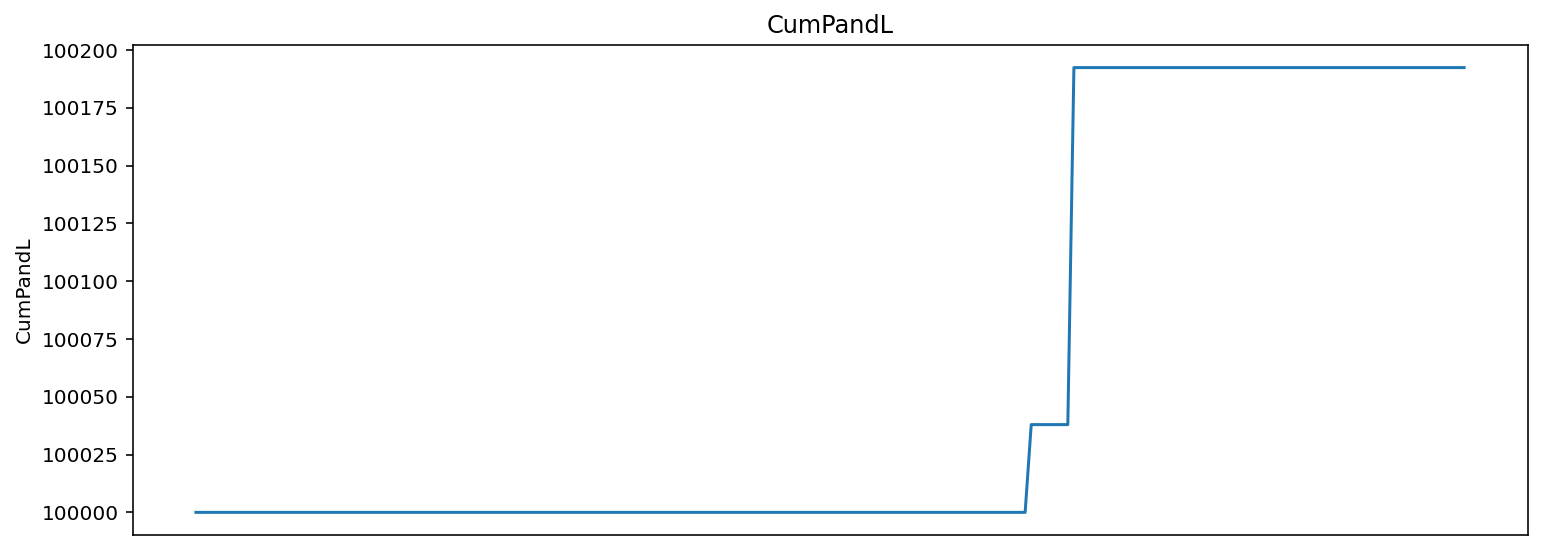

In [161]:
#Visualize the Data (NEW CODE)
plt.figure(figsize=(12.5, 4.5))

plt.plot(data_2['CumPandL'])

plt.title('CumPandL')
plt.xlabel('')
plt.ylabel('CumPandL')
plt.xticks([]) # remove dates which will cause noise
plt.show()

In [162]:
data_2 = data_2.reset_index()

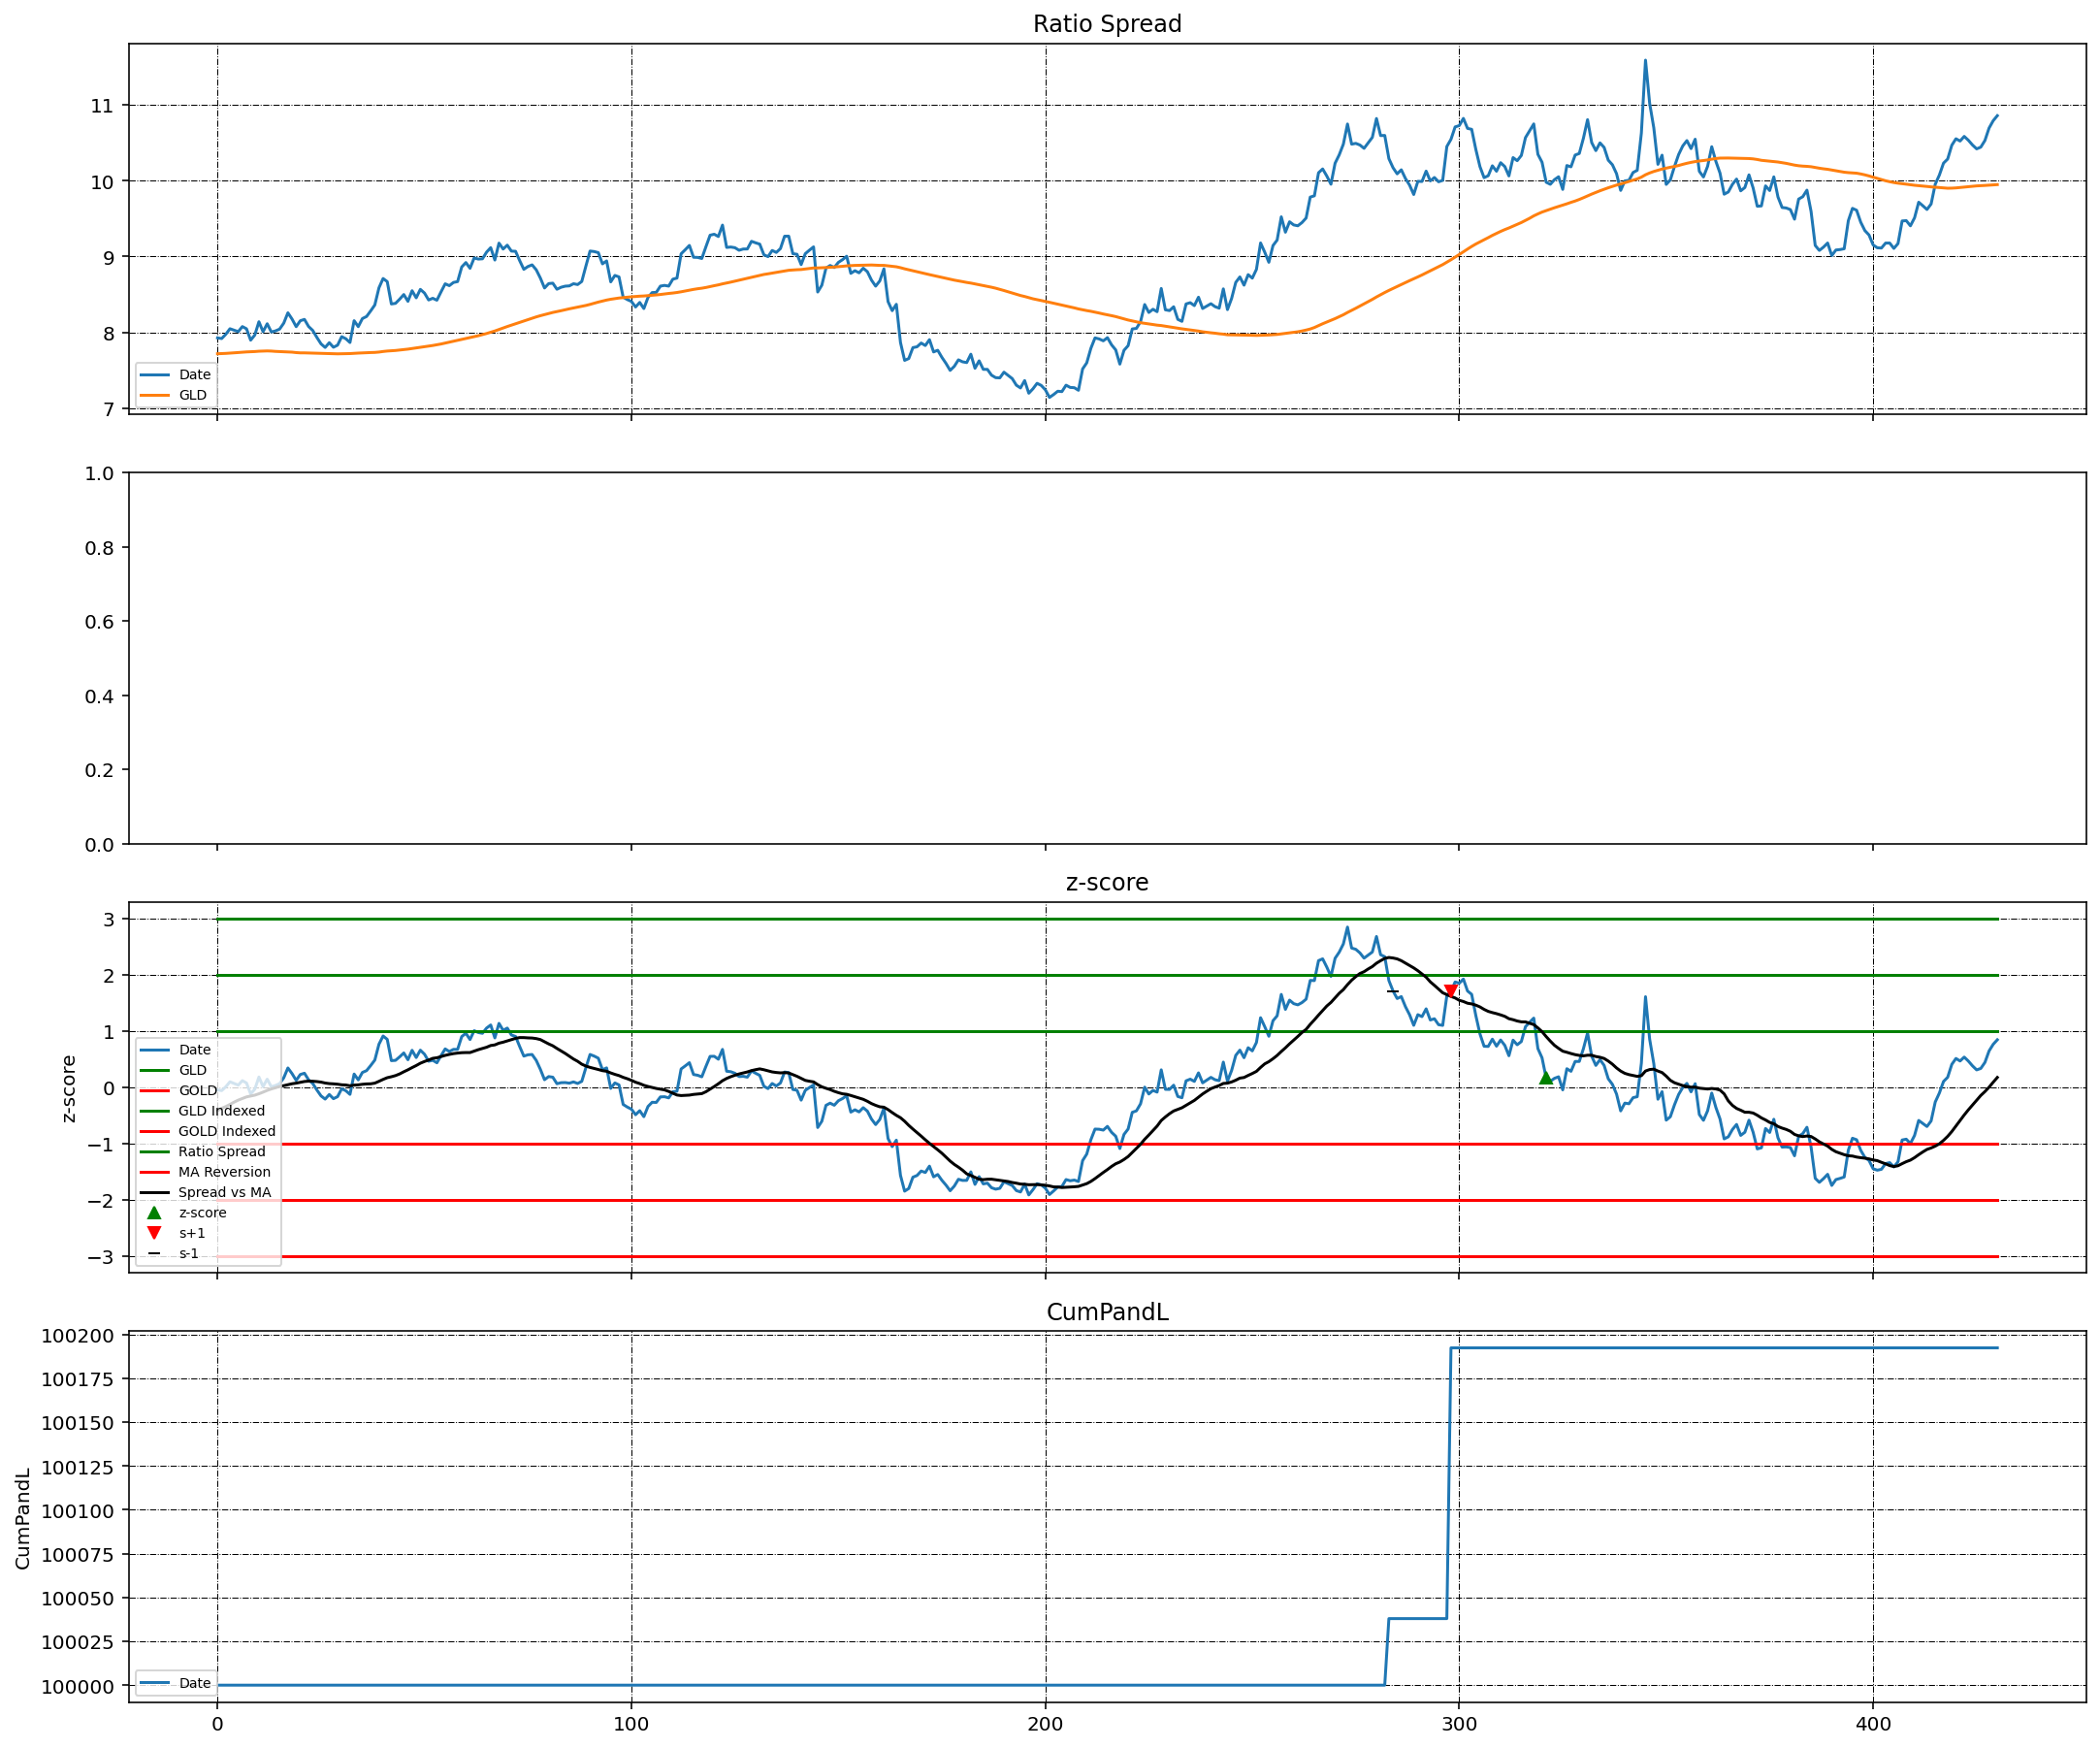

In [163]:
# Show a Graph of the SVR on Ratio and Spread z-score
#Initial Figure
fig, axs = plt.subplots(4, sharex=True, figsize=(15,13))
fig.suptitle('')
fig.tight_layout(pad=2.0)

# 1st graph
#Data
axs[0].plot(data['Ratio Spread'])
axs[0].plot(data['MA Reversion'])
#Layout
axs[0].set_title('Ratio Spread') # change to spread of the tickers
axs[0].legend(data, loc="lower left", prop={'size': 7}, shadow = False)
axs[0].set_ylabel('')
axs[0].grid(which="major", color='k', linestyle='-.', linewidth=0.5)



# 3rd graph
#Data
axs[2].plot(data['z-score'])
axs[2].plot(data['s+1'], label="s1", color="green")
axs[2].plot(data['s-1'], label="s-1", color="red")
axs[2].plot(data['s+2'], label="s2", color="green")
axs[2].plot(data['s-2'], label="s-2", color="red")
axs[2].plot(data['s+3'], label="s3", color="green")
axs[2].plot(data['s-3'], label="s-3", color="red")
axs[2].plot(data['MA Entry'], label="MA Entry", color="black")

axs[2].plot(entry_long_x, entry_long_y, 'g^', label = 'Buy/Cover order' ) #green arrows
axs[2].plot(entry_short_x, entry_short_y, 'rv', label = 'Sell/Short order') #red arrows
axs[2].plot(stop_loss_x, stop_loss_y, 'k_', label = 'Stop Loss') #black bars

#Layout
axs[2].set_title('z-score')
axs[2].legend(data, loc="lower left", prop={'size': 7}, shadow = False)
axs[2].set_ylabel('z-score')
axs[2].grid(which="major", color='k', linestyle='-.', linewidth=0.5)


# 4th graph
#Data
axs[3].plot(data_2['CumPandL'])
#Layout
axs[3].set_title('CumPandL')
axs[3].legend(data, loc="lower left", prop={'size': 7}, shadow = False)
axs[3].set_ylabel('CumPandL')
axs[3].grid(which="major", color='k', linestyle='-.', linewidth=0.5)

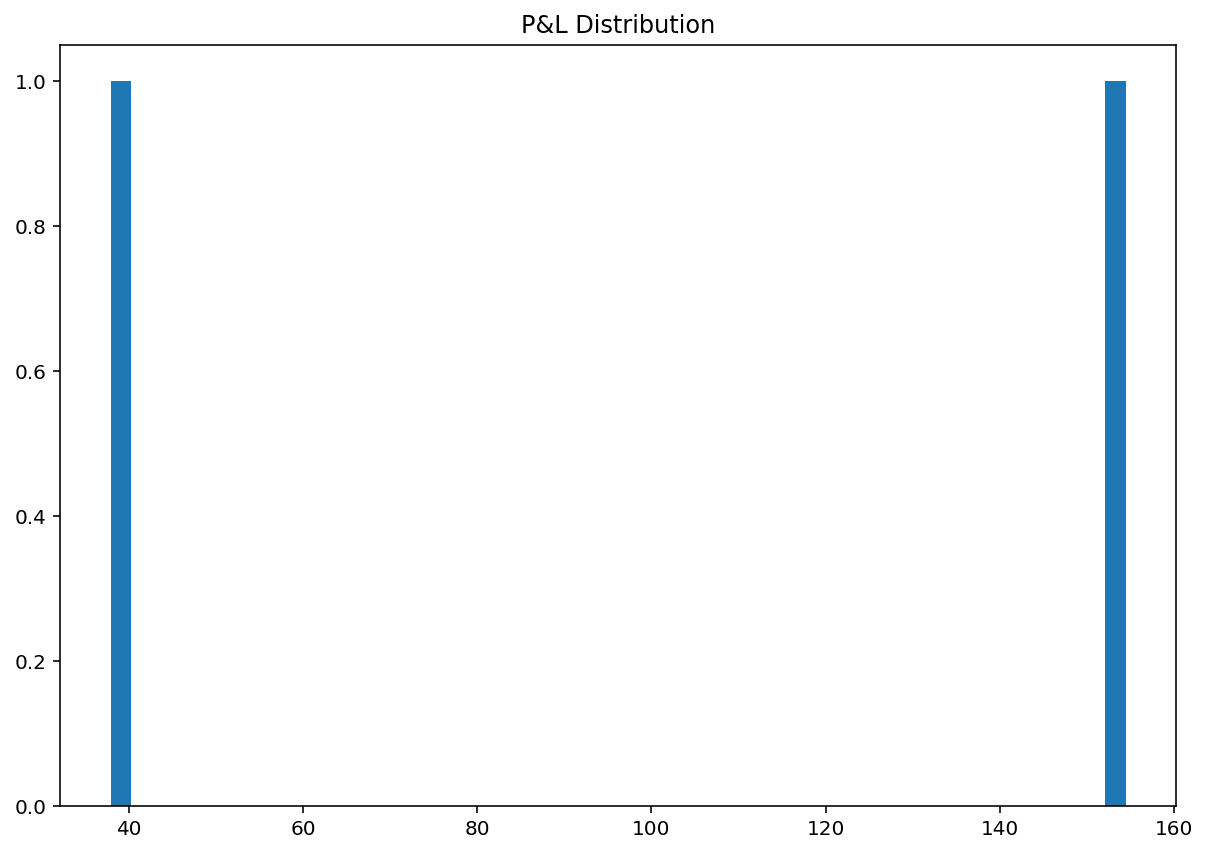

In [164]:
plt.figure(figsize=(10, 7))
plt.hist(data_2['PandL'], bins = 50)
plt.title('P&L Distribution')
plt.xlabel('')
plt.plot(label = 'Distribution')
plt.show()

#### Zoomed View

In [165]:
zoom_data = data[-200:]
zoom_data

,Date,GLD,GOLD,GLD Indexed,GOLD Indexed,Ratio Spread,MA Reversion,Spread vs MA,z-score,s+1,s-1,s+2,s-2,s+3,s-3,MA Entry,Buy_signal1,Sell_signal1,Stop_Loss_lvl,Take_Profit_lvl
231,2022-05-23,172.830002,20.730000,0.947897,0.841998,8.337193,8.063145,0.274048,0.036670,1,-1,2,-2,3,-3,-0.421998,NaN,NaN,NaN,NaN
232,2022-05-24,174.130005,21.309999,0.955027,0.865556,8.171282,8.054635,0.116647,-0.163602,1,-1,2,-2,3,-3,-0.392979,NaN,NaN,NaN,NaN
233,2022-05-25,173.080002,21.250000,0.949268,0.863119,8.144941,8.046105,0.098836,-0.186264,1,-1,2,-2,3,-3,-0.364955,NaN,NaN,NaN,NaN
234,2022-05-26,172.759995,20.629999,0.947513,0.837937,8.374212,8.039054,0.335158,0.114424,1,-1,2,-2,3,-3,-0.321128,NaN,NaN,NaN,NaN
235,2022-05-27,172.850006,20.600000,0.948006,0.836718,8.390777,8.032428,0.358349,0.143931,1,-1,2,-2,3,-3,-0.279142,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,2023-03-03,172.490005,16.520000,0.946032,0.670999,10.441283,9.933016,0.508267,0.334683,1,-1,2,-2,3,-3,-0.146130,NaN,NaN,NaN,NaN
427,2023-03-06,171.619995,16.299999,0.941260,0.662063,10.528835,9.936484,0.592351,0.441668,1,-1,2,-2,3,-3,-0.077147,NaN,NaN,NaN,NaN
428,2023-03-07,168.619995,15.770000,0.924807,0.640536,10.692453,9.940037,0.752416,0.645329,1,-1,2,-2,3,-3,0.001297,NaN,NaN,NaN,NaN
429,2023-03-08,168.539993,15.620000,0.924368,0.634444,10.790012,9.944358,0.845654,0.763962,1,-1,2,-2,3,-3,0.089550,NaN,NaN,NaN,NaN


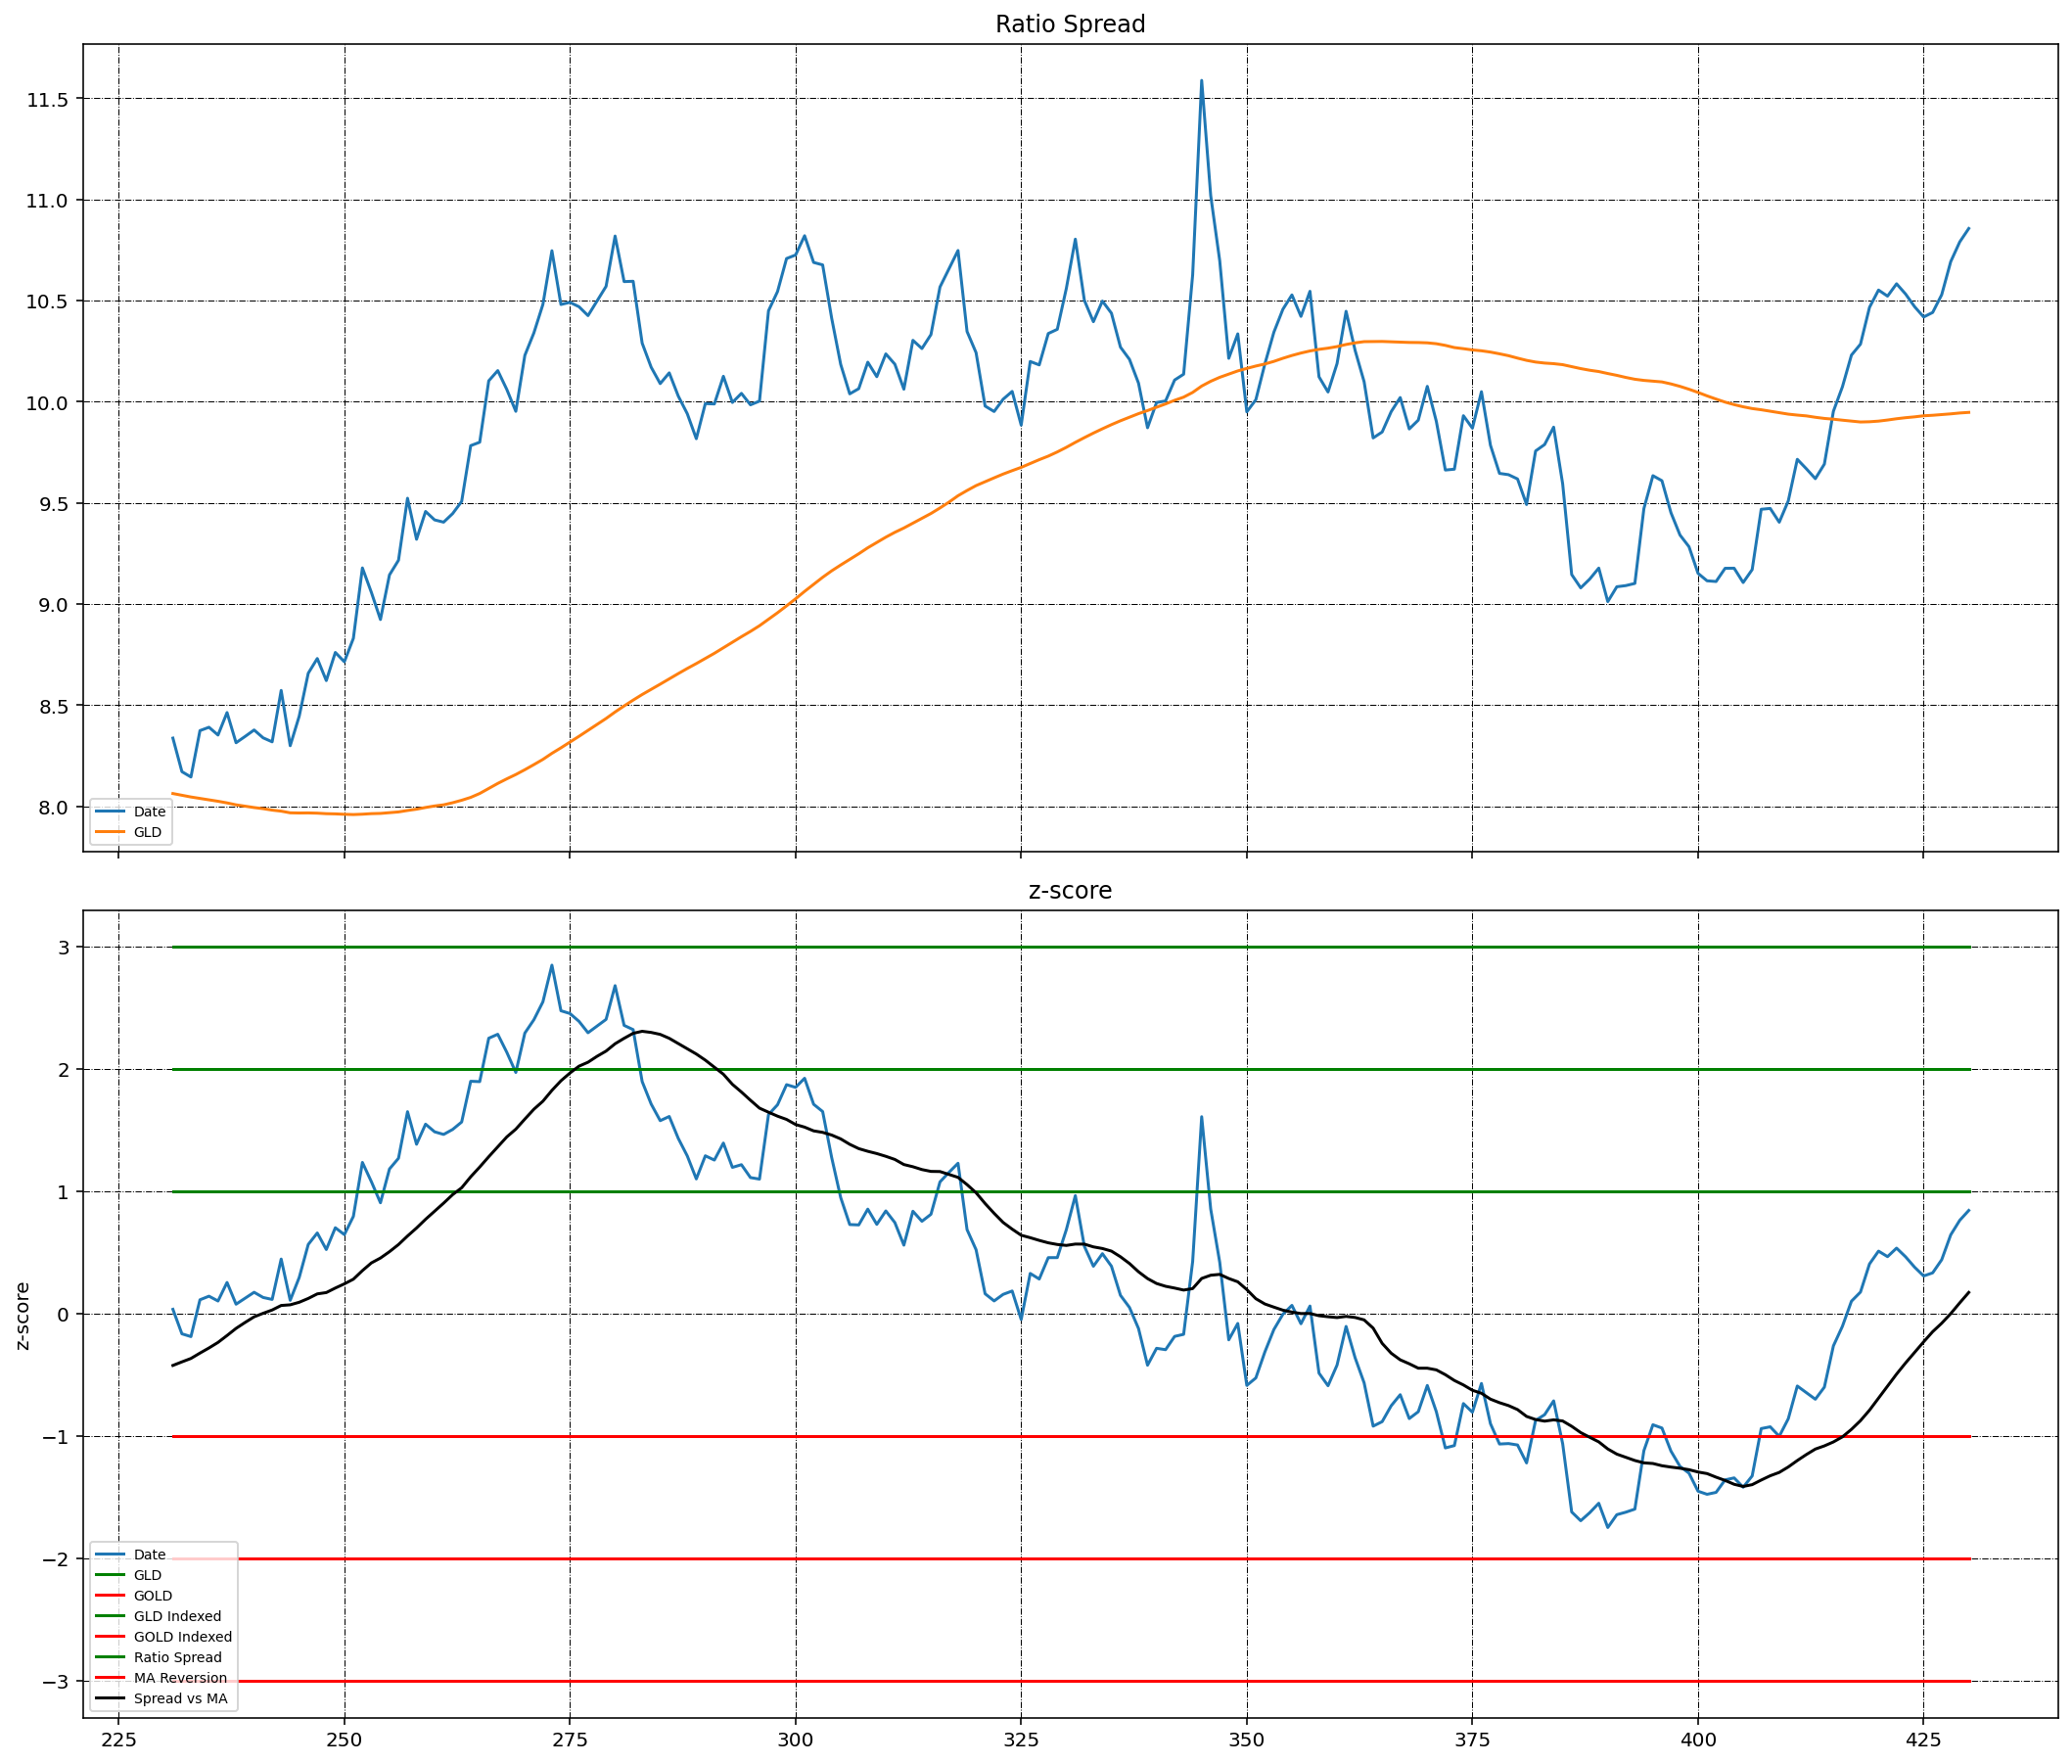

In [166]:
# Show a Graph of the SVR on Ratio and Spread z-score
#Initial Figure
fig, axs = plt.subplots(2, sharex=True, figsize=(15,13))
fig.suptitle('')
fig.tight_layout(pad=2.0)

# First graph

#Data
axs[0].plot(zoom_data['Ratio Spread'])
axs[0].plot(zoom_data['MA Reversion'])

#Layout
axs[0].set_title('Ratio Spread') # change to spread of the tickers
axs[0].legend(zoom_data, loc="lower left", prop={'size': 7}, shadow = False)
axs[0].set_ylabel('')
axs[0].grid(which="major", color='k', linestyle='-.', linewidth=0.5)


# Second graph
#Data
axs[1].plot(zoom_data['z-score'])
axs[1].plot(zoom_data['s+1'], label="s1", color="green")
axs[1].plot(zoom_data['s-1'], label="s-1", color="red")
axs[1].plot(zoom_data['s+2'], label="s2", color="green")
axs[1].plot(zoom_data['s-2'], label="s-2", color="red")
axs[1].plot(zoom_data['s+3'], label="s3", color="green")
axs[1].plot(zoom_data['s-3'], label="s-3", color="red")
axs[1].plot(zoom_data['MA Entry'], label="MA Entry", color="black")

#Layout
axs[1].set_title('z-score')
axs[1].legend(zoom_data, loc="lower left", prop={'size': 7}, shadow = False)
axs[1].set_ylabel('z-score')
axs[1].grid(which="major", color='k', linestyle='-.', linewidth=0.5)